In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
import os
import re
from IPython.display import clear_output
from random import sample
import random

In [ ]:
start_token = " "

def read_dataset(path_to_file):
  global start_token
  with open(path_to_file) as f:
    dataset = f.read()[:-1]
    #dataset = [start_token + line for line in dataset]
    return dataset

In [ ]:
try:
  dataset = read_dataset('dataset')
except FileNotFoundError:
  !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O dataset
  dataset = read_dataset('dataset')

In [ ]:
try:
  dataset = read_dataset('Борис Годунов.txt')
except:
  print("something wrong, i can feel it")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
#all unique characters go here
tokens = set()
tokens.update(" ")
for i, word in enumerate(dataset):
  tokens.update(word)
tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  136


In [ ]:
print(tokens[0:100])

['ы', 'ь', 'G', 'J', 'Н', 'е', 'а', 'И', 'Ф', 'Г', 'Ц', 'ж', '7', 'E', 'è', 'А', 'v', 'Ю', '3', 'Д', 'l', 'г', 'n', 'S', 'R', 'ф', 'б', 'р', '1', '4', ' ', 'Ь', 'ё', '—', 'ч', 'y', '«', "'", '-', 'ê', 'д', 'M', '.', 'é', '»', 'r', 'd', 'о', 'С', 'O', 'Т', 'b', 'Ш', 'к', 'ш', 'з', 'К', 'j', 'Р', '?', 'V', 'Х', 'B', '0', 'm', 'A', 'ç', 'в', ',', 'i', 'П', 'ц', 't', 'T', '\n', ')', 'п', ';', 'Е', '5', 'z', 'e', ':', 'н', 'C', 'ю', 'f', 'й', 'и', '8', 'Я', '!', 'с', 'у', 'Щ', 'o', 'à', 'О', 'x', 'х']


In [ ]:
token_to_id = {token : idx for idx, token in enumerate(tokens) }

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
def to_matrix(dataset, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of sequences into rnn-digestable matrix"""

    max_len = max_len or max(map(len, dataset))
    dataset_ix = np.zeros([len(dataset), max_len], dtype) + pad
    #print(max(map(len, dataset)))

    for i in range(len(dataset)):
        line_ix = [token_to_id[c] for c in dataset[i]]
        dataset_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        dataset_ix = np.transpose(dataset_ix)

    return dataset_ix

In [ ]:
MAX_LENGTH = 100
print(random.randint(0, len(dataset)))

26149


In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens = num_tokens, emb_size= 256, rnn_num_units= 512, dropout = 0.5, num_layers = 4):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.rnn_num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, num_layers = num_layers, dropout = dropout, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hidden):
        h_seq, hidden = self.rnn(self.emb(x), hidden)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden

    def init_hidden(self, batch_size=100):
        weight = next(self.parameters()).data

        hidden = (weight.new(self.num_layers, batch_size, self.rnn_num_units).zero_().to(device),
                  weight.new(self.num_layers, batch_size, self.rnn_num_units).zero_().to(device))

model = CharRNNLoop()
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
history = []

In [ ]:
sample_num = 100

In [ ]:
batch_size = 100
def batch_gen(dataset):
  batch = []
  for i in range(batch_size):
    random_num = random.randint(0, len(dataset)-sample_num)
    batch.append(dataset[random_num:random_num+sample_num])
  return batch

In [ ]:
# the model applies over the whole sequence
batch_ix = to_matrix(batch_gen(dataset), max_len=MAX_LENGTH)
batch_ix = torch.cuda.LongTensor(batch_ix)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
hidden = model.init_hidden(batch_size)
logp_seq, hidden = model(batch_ix, hidden)

# compute loss.
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens),
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

<ipython-input-15-d55a1a9fa235>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_ix = torch.tensor(batch_ix, dtype=torch.int64)


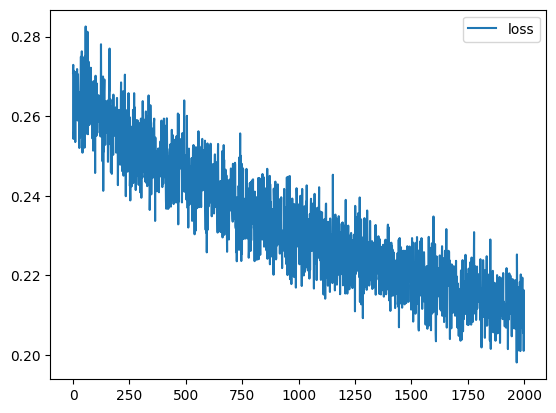

In [ ]:
model.train()
start_pos = len(history)
EPOCHS = 2000
for i in range(EPOCHS):
    model.zero_grad()
    batch_ix = to_matrix(batch_gen(dataset), max_len=MAX_LENGTH)
    batch_ix = torch.cuda.LongTensor(batch_ix)
    #batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    hidden = model.init_hidden(batch_size)
    logp_seq, hidden = model(batch_ix, hidden)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]).mean()

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.cpu().data.numpy())
    if (i+1)%5==0:
        clear_output(True)
        plt.plot(history[start_pos:], label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

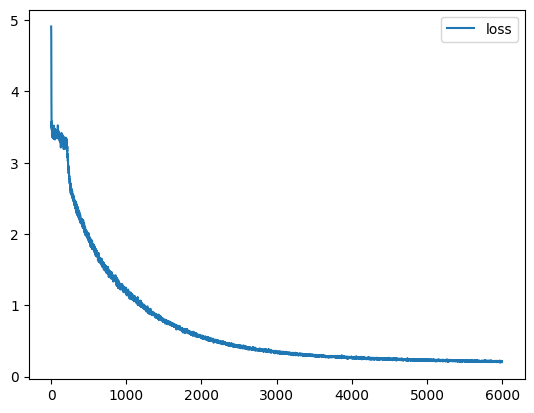

In [ ]:
clear_output(True)
plt.plot(history[0:],label='loss')
plt.legend()
plt.show()

In [ ]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    model.eval()
    model.to("cpu")
    hidden = model.init_hidden(batch_size)
    with torch.no_grad():
      x_sequence = [token_to_id[token] for token in seed_phrase]
      #x_sequence= torch.cuda.LongTensor([x_sequence])
      x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

      #feed the seed phrase, if any
      for i in range(len(seed_phrase) - 1):
          logp_next, hidden = model(x_sequence[:, i], hidden)

      #start generating
      for _ in range(max_length - len(seed_phrase)):
          logp_next, hidden = model(x_sequence[:, -1], hidden)
          p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

          # sample next token and push it back into x_sequence
          next_ix = np.random.choice(num_tokens,p=p_next)
          next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
          x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    model.to(device)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(1):
  print(generate_sample(model, max_length = 20000, temperature = 1))
  print(" ")

 царь ей он Думе
Нарежел, здесь; на тронные ступени,
Пока тобой не свержен Годунов,
Любви речей не буду слушать я.
(Уходит.)
Самозванец
Нет — легче мне сражаться с Годуновым
Или хитрить с придворным езуитом,
Чем с женщиной — черт с ними; мочи нет.
И путает, и вьется, и ползет,
Скользит из рук, шипит, грозит и жалит.
Змея! змея! — Недаром я дрожал.
Она меня чуть-чуть не погубила.
Но решено: заутра двину рать.
ГРАНИЦА ЛИТОВСКАЯ
(1604 года, 16 октября)
Князь Курбский и Самозванец,   оба   верхами.
Полки приближаются к границе.
Курбский
(прискакав первый)
Вот, вот она! вот русская граница!
Святая Русь, Отечество! Я твой!
Чужбины прах с презреньем отряхаю
С моих одежд — пью жадно воздух новый:
Он мне родной!.. теперь твоя душа,
О мой отец, утешится, и в гробе
Опальные возрадуются кости!
Блеснул опять наследственный наш меч,
Сей славный меч, гроза Казани темной,
Сей добрый меч, слуга царей московских!
В своем пиру теперь он загуляет
За своего надёжу-государя!..
Самозванец
(едет тихо с поникш

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
            'history': history
          }, './model')

In [ ]:
checkpoint = torch.load('./model')
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
loss = checkpoint['loss']